In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [3]:
## PIfunc that calculate Unique, Synergy and Redundancy of three unsymmetric varibles
def PIfunc(r, x, v, dt, window):
    joint = (max(v)+1)*x+v
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int8')
    # shifted data
    # shift>0 => y shifted to positive side
    MIx=np.zeros(len(bitshift))
    MIv=np.zeros(len(bitshift))
    Redun =np.zeros(len(bitshift))
    MIjoint =np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        jj=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            jj = joint[shift:]
            rr=r[:-shift]
        elif shift==0:
            xx=x
            vv=v
            jj = joint
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            jj = joint[:shift]
            rr=r[-shift:]
        pxr, xedges, yedges = np.histogram2d(xx, rr, bins=(np.unique(xx),np.unique(rr)), density = True)
        pvr, xedges, yedges = np.histogram2d(vv, rr, bins=(np.unique(vv),np.unique(rr)), density = True)
        pjr, xedges, yedges = np.histogram2d(jj, rr, bins=(np.unique(jj),np.unique(rr)), density = True)
        px=np.sum(pxr,axis=1)
        pv=np.sum(pvr,axis=1)
        pj=np.sum(pjr,axis=1)
        pr=np.sum(pjr,axis=0)
        
        MIx[i]=np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr))/dt
        MIv[i]=np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr))/dt
        MIjoint[i]=np.nansum(pjr*np.log2(pjr/pj.reshape(-1,1)/pr))/dt
        
        PI_rX = np.nansum(pxr*np.log2(pxr/px.reshape(-1,1)/pr), axis = 0)
        PI_rV = np.nansum(pvr*np.log2(pvr/pv.reshape(-1,1)/pr), axis = 0)
        Redun[i] = sum(np.minimum(PI_rX, PI_rV))/dt
    return timeshift, MIx, MIv, MIjoint, Redun

In [24]:
#main
# OU ; input
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
tau=1
D = 4
L=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    L[i+1]=L[i]*(0.5-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    
# filtering for OUSmoothed
cutoffFreq = 0.5
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
x = signal.filtfilt(b, a, L)
#v = ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt
v = np.diff(x)/dt
x=x[1:]
v=v[0:] #cut ends.  V(n) = X(n) -X(n-1)
T=T[1:]

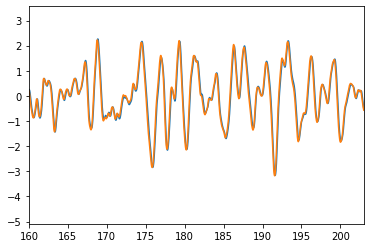

In [30]:
##response
# Model one: simple estimation
deltaT = 2
r1 = x+v*deltaT

# Model Two: negative group delay
# #following paremeters match x+v*0.5s
# alpha = 60.
# beta =  2
# K = 30.
# g = 30.
#following paremeters match x+v*2s
alpha = 19.9
beta =  0.62
K = 10
g = 30
y=np.zeros(len(T))
z=np.zeros(len(T))
for j in range(len(T)-1):
    dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
    dz=dt*(-beta*z[j]+g*y[j])
    y[j+1]=y[j]+dy
    z[j+1]=z[j]+dz

y= y/np.std(y)
r1= r1/np.std(r1)
plt.plot(T,y)
plt.plot(T,r1)
plt.xlim(160,203)
    
#Chose which one to be response
r = r1

In [31]:
#assign states
edges = np.append(min(r), np.array([np.std(r),2*np.std(r),3*np.std(r)])+np.mean(r));
rstate=np.zeros(len(r))
for i in range(4):
    rstate[r>=edges[i]] = i
rstate = rstate.astype(int)
xstate = EqualState(x, 6)
vstate = EqualState(v, 6)

In [32]:
#calculate information
window = [-1,1] # second
timeshift, MIx, MIv, MIjoint, Redun = PIfunc(rstate, xstate, vstate, dt, window)
Ux = MIx-Redun
Uv = MIv-Redun
Syner = MIjoint-MIx-MIv+Redun

C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
C:\Users\llinc\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply
C:\Users\llinc\anaconda3\lib

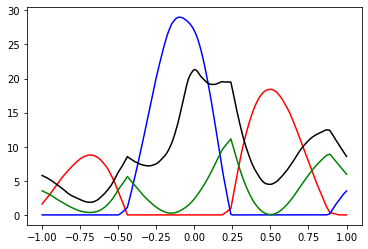

In [33]:
#plot PIs
plt.plot(timeshift,Ux, 'r-')
plt.plot(timeshift,Uv, 'b-')
plt.plot(timeshift,Syner, 'k-')
plt.plot(timeshift,Redun, 'g-')

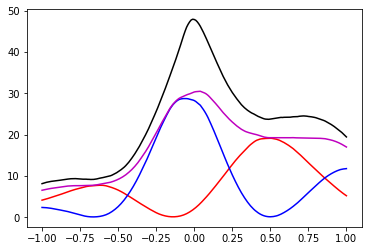

In [9]:
#plot MIs
plt.plot(timeshift,MIx, 'r-')
plt.plot(timeshift,MIv, 'b-')
plt.plot(timeshift,MIjoint, 'k-')
plt.plot(timeshift,MIx+MIv, 'm-')